<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%203/Case_Study_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
###############################################
# Open (and close!) a file for reading.  File
# is closed automatically by using the "with"
# statement
#  After the file_name
#'r' stands for read, 
# 'w' standsfor write
# 'b' stands for binary
# they can be used together aka 'rb', 'wb', 'rw'
################################################
import os
file_name = "/content/drive/MyDrive/SpamAssassinMessages/easy_ham/00001.7c53336b37003a9286aba55d2945844c"
with open(file_name,'r') as file_handle:
    x = file_handle.read()
    
print(x)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [6]:
x

'From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002\nReturn-Path: <exmh-workers-admin@spamassassin.taint.org>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)\nReceived: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for\n    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100\nReceived: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by\n    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002\n    07:35:02 -0400 (EDT)\nDelivered-To: exmh-workers@listman.spamassassin.taint.org\nReceiv

In [7]:
###############################
# Anything after a "\" is a control character
# the most common is \n, but there is as many 
# as there are letters and numbers
# You can remove them with .replace("old_thing","new_thing")
#  This works for any character not just control characters
# Adavnaced replacement can be done with regular expressions
###################################
x = "Hello\nThere"
print(x)
x = "Hello\tThere"
print(x)
x = "I have all\n\n\n sorts of \n characters"
print(x.replace('\n',''))

Hello
There
Hello	There
I have all sorts of  characters


In [8]:
x = os.listdir('/content/drive/MyDrive/SpamAssassinMessages/easy_ham')
x

['01081.844461cf79fe409cdfed1c9456c064f0',
 '01090.a6575cc193fe3bb9f143aa0eb4fed7ac',
 '01173.30be73e4da024638bfbdf5afc05b438f',
 '01102.d178bf64121423fea27fcbf754d5f984',
 '01113.444c4a1faf97d17bc580aea2905b773b',
 '01104.703f48a4a1fa8c0e7053fba23997ee81',
 '01096.0ecf28b2697d77f7039d82f8838bcf8d',
 '01085.15903c3e109d4d35eae6bf5ef80acf77',
 '01076.3a56372738701391cf04b8a1fd379d3b',
 '01170.ff1eb252e91b1481ee0a2887eb862c16',
 '01152.94d97f41bdf572892508e21b3906aa3b',
 '01107.18f0cd87bd40e5c64270187a75d668e8',
 '01167.6c1a9d12bb40059b2b3aba3d1c5c0f3c',
 '0110.0bb9a36c3037be09867c0251e0fd6a3a',
 '01097.08d3f921b8b1e6627c89504ea1c14069',
 '01270.49d052edd258d0f9eb08ca05e177f965',
 '01266.94c891b6d36df9a9c187a71e7d90eb83',
 '01179.bf1aa6047c74cad4860b8010439f199a',
 '01252.60a457d292a0e9c1307a196324d298dc',
 '01192.bf5336caa5be79062f70233fa759a1b8',
 '01255.3b6925695108a60022e1557430f4973f',
 '01254.e1ba700d620871e67b4f7db4b8859ac3',
 '0123.32e1738c4171dd9d70b727fd7973a291',
 '01234.868bd

In [11]:
############################
# The os package is great for listing files
# and doing things in python you usually do 
# on the command line
###########################
import os
file_list = os.listdir('/content/drive/MyDrive/SpamAssassinMessages/easy_ham')
print(len(file_list))
print("\n\n")

#######################
# Open the 5th file of the directory listing and print it
# Note that I used os.path.join(1st_item,2nd_item) to create 
# a full path
#######################
base_dir = '/content/drive/MyDrive/SpamAssassinMessages/easy_ham'
with open(os.path.join(base_dir,file_list[4]),'r') as file_handle:
    msg = file_handle.read()
    
print(msg)

5052



From rpm-list-admin@freshrpms.net  Thu Sep 19 13:02:21 2002
Return-Path: <rpm-zzzlist-admin@freshrpms.net>
Delivered-To: yyyy@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id 100B516F03
	for <jm@localhost>; Thu, 19 Sep 2002 13:02:21 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Thu, 19 Sep 2002 13:02:21 +0100 (IST)
Received: from egwn.net (ns2.egwn.net [193.172.5.4]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8JBC9C16961 for
    <jm-rpm@jmason.org>; Thu, 19 Sep 2002 12:12:09 +0100
Received: from auth02.nl.egwn.net (localhost [127.0.0.1]) by egwn.net
    (8.11.6/8.11.6/EGWN) with ESMTP id g8JB91f09494; Thu, 19 Sep 2002 13:09:01
    +0200
Received: from python (gw01.es3.egwn.net [212.9.66.13]) (authenticated) by
    egwn.net (8.11.6/8.11.6/EGWN) with ESMTP id g8JB8Wf08829 for
    <rpm-list@freshrpms.net>; Thu, 19 Sep 20

In [12]:
######################
# Multiple directories?
# No problem--use os.walk()
# Notice how mine does the screwy windows \\ vs /
# it still works for windows though
# and of course linux/apple works fine
#####################
file_list = []
for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/", topdown=False):
    for name in files:
        tmp = os.path.join(root,name)
        file_list.append(tmp)
    for item in dirs:
        print(item)

print("\n\n")
print(file_list[0:10])

spam_2
spam
easy_ham_2
easy_ham
hard_ham



['/content/drive/MyDrive/SpamAssassinMessages/spam_2/00553.4e22bb923ee41a61d04f8b275157366b', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00724.edc5a3ce2ea91fedbf00aa0c30459a87', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00585.0cc56d33bcfde91ab75bf202e4684c4a', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00653.dcb006e0c0aaa7aa3e5bd7cb3d444f23', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00484.602c7afb217663a43dd5fa24d97d1ca4', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00591.962cc31322a42abd7ca205b62c56438e', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00543.e69bd0a0effd4a12537fb358d79ea337', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00463.0bc4e08af0529dd773d9f10f922547db', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00458.49467dba97d6ac2825c533df9a7a5017', '/content/drive/MyDrive/SpamAssassinMessages/spam_2/00519.f189e2f1541968e48de6ebd9db23b35d']


In [13]:
#######################
# Lets look at the email package
# it has two important methods
# get_payload() and get_content_type()
#  I'll start with the get_payload() 
# which gets the contents of the email
######################

import email

for i in range(10):
    with open(file_list[i],"r") as f:
        message = email.message_from_file(f)
        body = message.get_payload()
        print("**********START**************\n")
        print(body)
        print("**********END**************\n")

**********START**************

How would you like a Top Rated Law Firm working for you, your family and your business for only pennies a day?
   
CLICK HERE
http://211.78.96.11/legalservices/
   
Get full details on this great service! FREE!
   
Whether it's a simple speeding ticket or an extensive child custody case, we cover all areas of the legal system.
   
 * Court Appearances on Your Behalf
 * Unlimited Phone Consultations
 * Review of ALL Your Legal Documents & Contracts
 * Take Care of Credit Problems
   
And that is just the beginning!
 
CLICK HERE
http://211.78.96.11/legalservices/
to get full details on this great service!
   
   
   
   
   
**********************************************
Simple Removal instructions:
To be removed from our in-house list simply visit
http://211.78.96.11/removal/remove.htm
Enter your email addresses to unsubscribe.


**********END**************

**********START**************

SUBJECT: 
                   Urgent Concern Pls.

I am a serious off

In [14]:
#################################
#  I will use get_content_type()
# to find a multipart message.
# Notice the body is not text anymore
# but more messages!!!  This is a problem to solve
# for case study
###################
for i in file_list:
    with open(i,"r") as f:
        message = email.message_from_file(f)
        if 'multipart' in message.get_content_type():
            body = message.get_payload()
            break
        else:
            pass

In [15]:
body

In [16]:
contents = []
types = []
labels = []
for root, dirs, files in os.walk("G:\\datasets\\SpamAssassinMessages\\"):
    for name in files:
        with open(os.path.join(root,name),'r') as f:
            try:
                x = email.message_from_file(f)
            except UnicodeDecodeError:  
                print(f"Oh no, you better figure out what is wrong with file {os.path.join(root,name)}")
                print("https://letmegooglethat.com/?q=UnicodeDecodeError")
            if "multipart" in x.get_content_type():
                # do something
                contents.append("")
            elif "text/plain" in x.get_content_type():  #boy I hope all text messages are the same!
                contents.append(x.get_payload().replace("\n"," "))
            elif "html" in x.get_content_type():
                # do something else
                contents.append("")
            types.append(x.get_content_type())
            if "ham" in root:
                labels.append(0)
            elif "spam" in root:
                labels.append(1)
            else:
                print("YOU HAVE A BIG PROBLEM--LABEL NOT FOUND")
                
        

In [ ]:
############################
# What kind of content in the email
# Most are text, some are html
# you can use your favorite email parser 
# to get text from those
# some are multipart--guess you can use
# get_content_type and get_paylod to 
# figure out a way to access those
# Maybe some recursion?
##############################
import pandas as pd
types = pd.DataFrame(types)
print(types.value_counts())
        

text/plain                     7403
text/html                      1199
multipart/alternative           328
multipart/mixed                 181
multipart/signed                180
multipart/related                56
multipart/report                  5
text/plain charset=us-ascii       1
dtype: int64


In [ ]:
len(contents)

9353

In [ ]:
data = pd.DataFrame({"Text":contents,"Label":labels})

In [ ]:
data[data['type'].str.contains("html")]

In [ ]:
data

,Text,Label
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
1,"Martin A posted: Tassos Papadopoulos, the Gree...",0
2,Man Threatens Explosion In Moscow Thursday A...,0
3,Klez: The Virus That Won't Die Already the m...,0
4,"> in adding cream to spaghetti carbonara, whi...",0
...,...,...
9348,,1
9349,"Dear Subscriber, If I could show you a way to...",1
9350,****Mid-Summer Customer Appreciation SALE!****...,1
9351,ATTN:SIR/MADAN ST...,1


text/plain                     7413
text/html                      1193
multipart/alternative           326
multipart/signed                180
multipart/mixed                 179
multipart/related                56
multipart/report                  5
text/plain charset=us-ascii       1
dtype: int64

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
out = vectorizer.fit_transform(data['Text'])

In [ ]:
vectorizer.vocabulary_

{'date': 27863,
 'wed': 69382,
 '21': 6051,
 'aug': 18705,
 '2002': 5815,
 '10': 4127,
 '54': 9823,
 '46': 8968,
 '0500': 3380,
 'from': 36105,
 'chris': 24431,
 'garrigues': 36617,
 'cwg': 27149,
 'dated': 27868,
 '1030377287': 4214,
 '06fa6d': 3485,
 'deepeddy': 28371,
 'com': 25280,
 'message': 47303,
 'id': 40171,
 '1029945287': 4203,
 '4797': 9069,
 'tmda': 65414,
 'vircio': 68444,
 'can': 23118,
 'reproduce': 57446,
 'this': 65023,
 'error': 32850,
 'for': 35565,
 'me': 47010,
 'it': 42184,
 'is': 42027,
 'very': 68213,
 'repeatable': 57363,
 'like': 45098,
 'every': 33144,
 'time': 65271,
 'without': 69947,
 'fail': 34214,
 'the': 64792,
 'debug': 28227,
 'log': 45525,
 'of': 50782,
 'pick': 53326,
 'happening': 38448,
 '18': 5206,
 '19': 5312,
 '03': 3233,
 'pick_it': 53327,
 'exec': 33314,
 'inbox': 40788,
 'list': 45270,
 'lbrace': 44585,
 'subject': 63075,
 'ftp': 36207,
 'rbrace': 56392,
 '4852': 9118,
 'sequence': 59981,
 'mercury': 47261,
 '04': 3304,
 'ftoc_pickmsgs': 36

In [ ]:
data.iloc[0,0]

'    Date:        Wed, 21 Aug 2002 10:54:46 -0500     From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>     Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>     | I can\'t reproduce this error.  For me it is very repeatable... (like every time, without fail).  This is the debug log of the pick happening ...  18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury} 18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury 18:19:04 Ftoc_PickMsgs {{1 hit}} 18:19:04 Marking 1 hits 18:19:04 tkerror: syntax error in expression "int ...  Note, if I run the pick command by hand ...  delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury 1 hit  That\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m using is ...  delta$ pick -version pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 1

In [ ]:
<unk>
            

64792

In [ ]:
reverse={}
for word,value in vectorizer.vocabulary_.items():
    reverse[value]=word

In [ ]:
reverse[64792]

'the'

In [ ]:
for i in range(out[0].shape[1]):
    if out[0,i]>0:
        print(reverse[i], out[0,i])

03 2
04 3
0500 1
06fa6d 1
10 1
1029945287 1
1030377287 1
14 1
17 1
18 5
19 5
2002 2
21 1
46 1
4797 1
4852 6
54 1
55 1
56 1
_______________________________________________ 1
able 1
actually 1
ago 1
and 2
at 1
au 1
aug 1
been 1
both 1
by 1
can 1
chris 1
code 1
com 4
comes 2
command 3
compiled 1
created 1
cs 1
cvs 1
cwg 1
date 1
dated 1
day 1
debug 1
deepeddy 2
delta 3
do 1
error 2
every 1
exec 2
exmh 3
explicit 1
expression 1
fail 1
for 1
form 1
from 4
ftoc_pickmsgs 1
ftp 3
fuchsia 1
garrigues 1
get 1
hand 1
happening 1
haven 1
hit 3
hits 1
https 1
ict 1
id 1
if 1
in 1
inbox 3
int 1
is 4
issue 1
it 1
kre 1
lbrace 6
like 1
line 1
list 5
listinfo 1
listman 1
local 1
log 1
mailing 1
mailman 1
mar 1
marking 1
me 1
mercury 3
message 1
mh_profile 2
mhparam 1
mu 1
my 1
nmh 2
note 1
obviously 1
of 5
on 2
one 2
oz 1
part 1
pick 9
pick_it 1
popup 1
ps 1
rbrace 6
reach 1
redhat 2
relevant 1
repeatable 1
repository 1
reproduce 1
routing 1
run 1
search 1
sel 1
seq 1
sequence 4
since 1
still 1
subject

In [ ]:
out[0,0]

0

In [ ]:
vectorizer.vocabulary_['unk']

KeyError: 'unk'

In [ ]:
<unk> = 102
<start> = 101
<end>= 3
<pad> = 100
<cls>

In [ ]:
"<pad> <pad> <start> The <unk> car drove away <end>"

In [ ]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
word_counts = CountVectorizer()
v_data = word_counts.fit_transform(data['data'])
v_test = word_counts.transform(test['data'])

In [ ]:
v_data

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.naive_bayes import ComplementNB, BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
comp = ComplementNB()
bern = BernoulliNB()
gaus = GaussianNB()
cat = CategoricalNB()
multi = MultinomialNB()
methods = {"Complement":comp,"Bernoulli":bern,"Gausian":gaus,"Multi":multi,"Cat":cat}
for i in methods.keys():
    try:
        methods[i].fit(v_data,data['target'])
        p = methods[i].predict(v_test)
        print(accuracy_score(test['target'],p), f"method={i}")
        print(classification_report(test['target'],p))
    except:
        print(f"{i} failed")


0.8267392458842273 method=Complement
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       319
           1       0.76      0.77      0.76       389
           2       0.85      0.31      0.46       394
           3       0.62      0.79      0.69       392
           4       0.84      0.82      0.83       385
           5       0.73      0.88      0.80       395
           6       0.88      0.70      0.78       390
           7       0.90      0.92      0.91       396
           8       0.93      0.97      0.95       398
           9       0.91      0.94      0.92       397
          10       0.89      0.99      0.94       399
          11       0.84      0.97      0.90       396
          12       0.82      0.70      0.76       393
          13       0.88      0.89      0.88       396
          14       0.83      0.94      0.88       394
          15       0.81      0.95      0.87       398
          16       0.74      0.91      0.82 

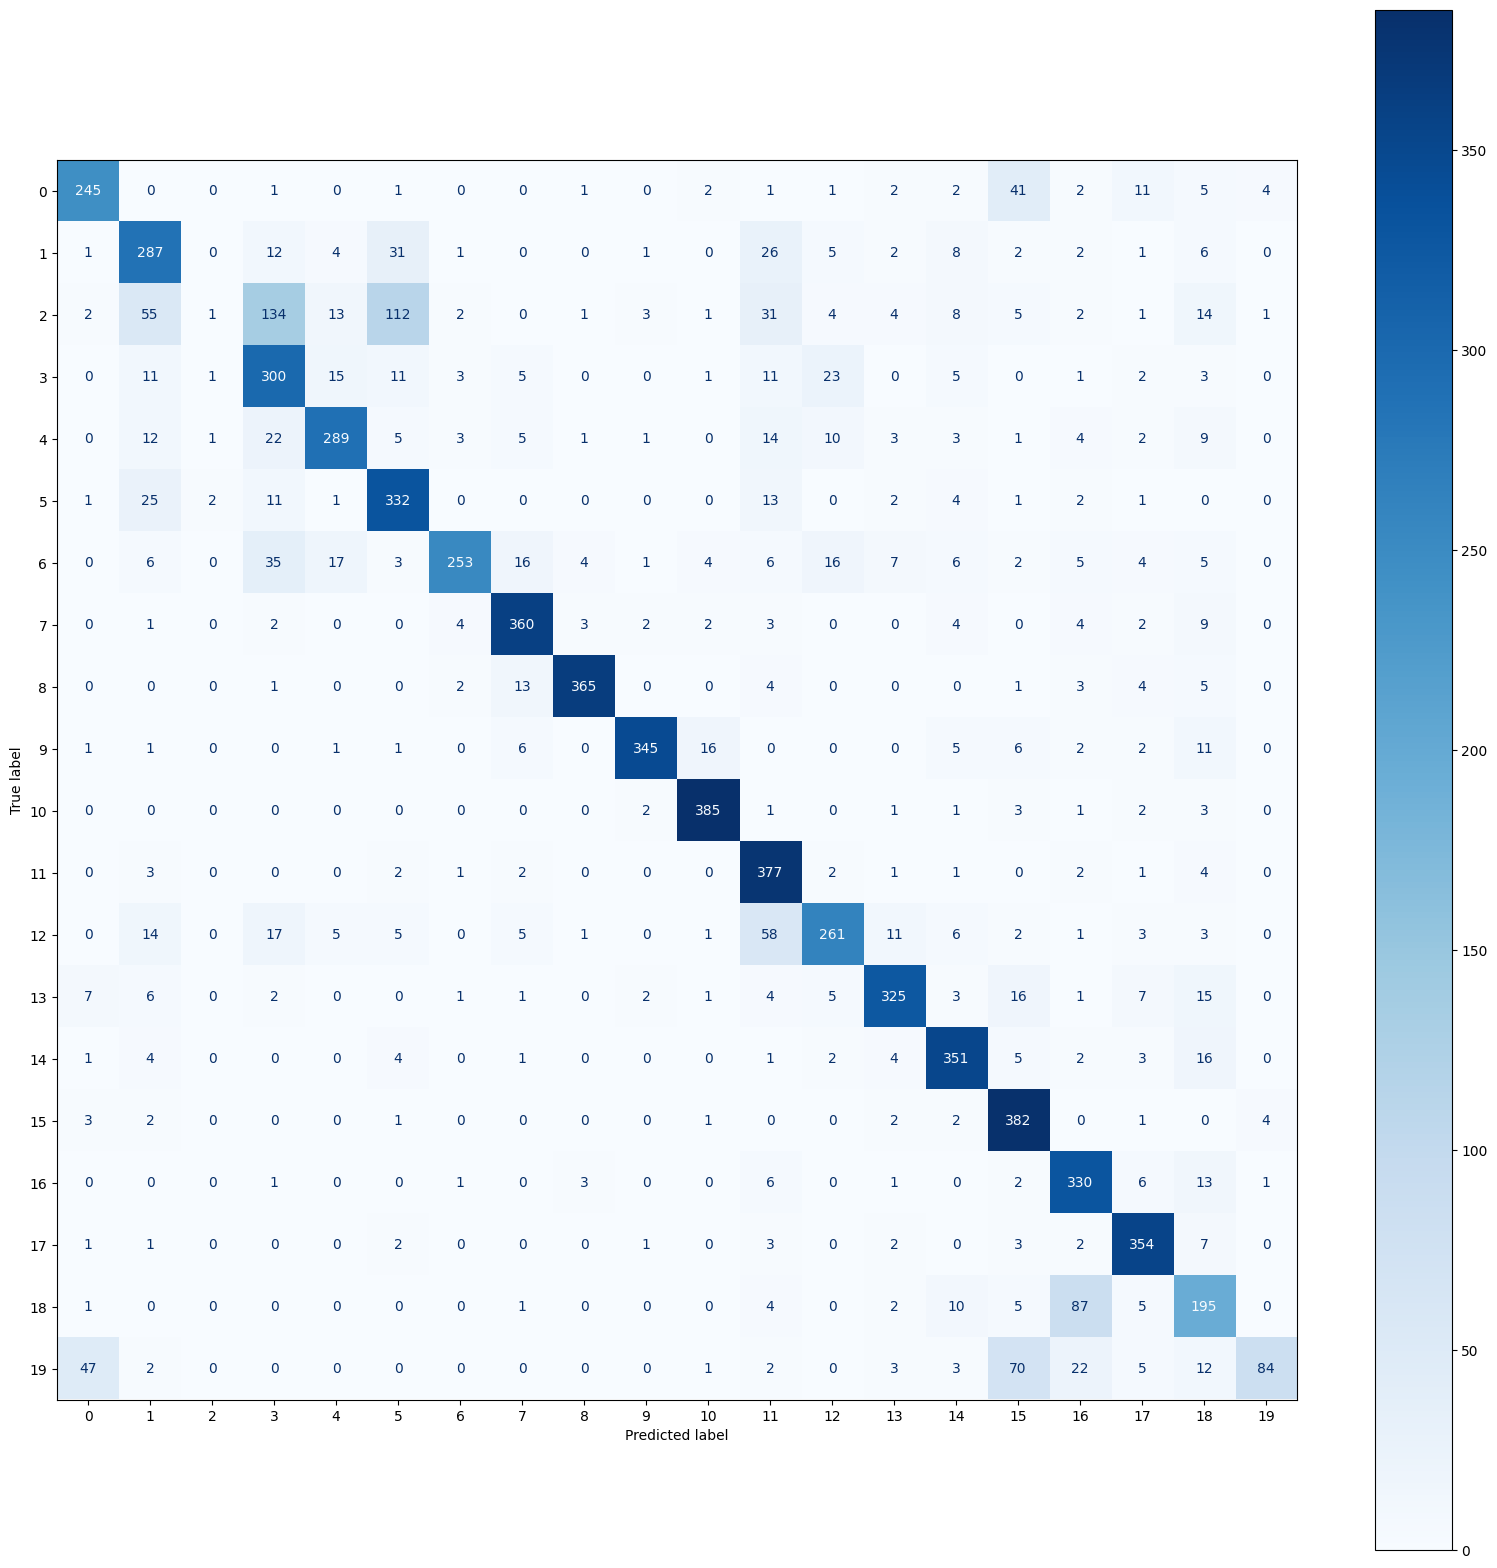

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
ConfusionMatrixDisplay.from_predictions(test['target'],p,cmap='Blues')

In [ ]:
reverse={}
for word,value in word_counts.vocabulary_.items():
    reverse[value]=word